In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from diffusion_policy_3d.env.adroit.adroit import AdroitEnv
import torch
from PIL import Image
import torchvision.transforms as T

def load_and_process_images(image_dir="adroit_camera_test", target_size=(168, 168)):
    """
    Load images from directory, resize them to target_size, and normalize to [0,1]
    
    Args:
        image_dir (str): Directory containing the images
        target_size (tuple): Target size for resizing (height, width)
    
    Returns:
        dict: Dictionary mapping filenames to processed torch tensors
    """
    # Define transforms
    transforms = T.Compose([
        T.Resize(target_size),
        T.ToTensor(),  # This also normalizes to [0,1]
    ])
    
    # Initialize dictionary to store processed images
    processed_images = {}
    
    # Process each image in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert('RGB')            
            # Apply transforms
            img_tensor = transforms(img)
            
            # Store in dictionary
            processed_images[filename] = img_tensor
            
            print(f"Processed {filename}: shape {img_tensor.shape}")
    
    return processed_images


processed_images = load_and_process_images()
processed_images.keys()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Processed high_right.png: shape torch.Size([3, 168, 168])
Processed high_left.png: shape torch.Size([3, 168, 168])
Processed high_front_right.png: shape torch.Size([3, 168, 168])
Processed fixed.png: shape torch.Size([3, 168, 168])
Processed top.png: shape torch.Size([3, 168, 168])
Processed high_back_right.png: shape torch.Size([3, 168, 168])
Processed high_back_left.png: shape torch.Size([3, 168, 168])
Processed high_front_left.png: shape torch.Size([3, 168, 168])
Processed high_back.png: shape torch.Size([3, 168, 168])
Processed vil_camera.png: shape torch.Size([3, 168, 168])
Processed high_front.png: shape torch.Size([3, 168, 168])


/home/san/dp3/3D-Diffusion-Policy/third_party/gym-0.21.0/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


dict_keys(['high_right.png', 'high_left.png', 'high_front_right.png', 'fixed.png', 'top.png', 'high_back_right.png', 'high_back_left.png', 'high_front_left.png', 'high_back.png', 'vil_camera.png', 'high_front.png'])

In [2]:
device = 'cuda'
image_batch = torch.stack([processed_images[k] for k in processed_images.keys()])
image_batch = image_batch.to(device)
print(image_batch.shape)

torch.Size([11, 3, 168, 168])


In [3]:
image_batch = image_batch.unsqueeze(0)
image_batch.shape

torch.Size([1, 11, 3, 168, 168])

In [4]:
image_batch[:, :2, ...].shape

torch.Size([1, 2, 3, 168, 168])

In [5]:
import sys, os
sys.path.append('/home/san/dp3/vggt')
from vggt.models.vggt import VGGT
import time

import torch 

def load_vggt(image_batch, device="cuda"):
    v = VGGT()
    url = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    v.load_state_dict(torch.hub.load_state_dict_from_url(url))
    v.to(device)
    v.eval()
    vggt_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
    print(image_batch.shape)
    start_time = time.time()
    with torch.no_grad():
        with torch.amp.autocast('cuda', dtype=vggt_dtype):
            # Predict attributes including cameras, depth maps, and point maps.
            predictions = v(image_batch)
            tokens, pos_idx = v.aggregator(image_batch)
            tokens = tokens[-1][:, :, pos_idx:, :]

    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")

    return v, vggt_dtype, predictions, tokens


_, _, vggt_predictions, vggt_tokens = load_vggt(image_batch)
print(vggt_tokens.shape, vggt_predictions['images'].shape)

torch.Size([1, 11, 3, 168, 168])
Time taken: 0.2789027690887451 seconds
torch.Size([1, 11, 144, 2048]) torch.Size([1, 11, 3, 168, 168])


/home/san/dp3/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [ ]:
# Number of views affects the time taken!
# _, _, vggt_predictions = load_vggt(image_batch[:, :3, ...])

torch.Size([1, 3, 3, 168, 168])
Time taken: 0.0389556884765625 seconds


In [31]:
vggt_predictions['depth'].shape, vggt_predictions['images'].shape

(torch.Size([1, 3, 168, 168, 1]), torch.Size([1, 3, 3, 168, 168]))

(1, 11, 3, 168, 168) (1, 11, 168, 168, 1)
0 (3, 168, 168)
1 (3, 168, 168)
2 (3, 168, 168)
3 (3, 168, 168)
4 (3, 168, 168)
5 (3, 168, 168)
6 (3, 168, 168)
7 (3, 168, 168)
8 (3, 168, 168)
9 (3, 168, 168)
10 (3, 168, 168)


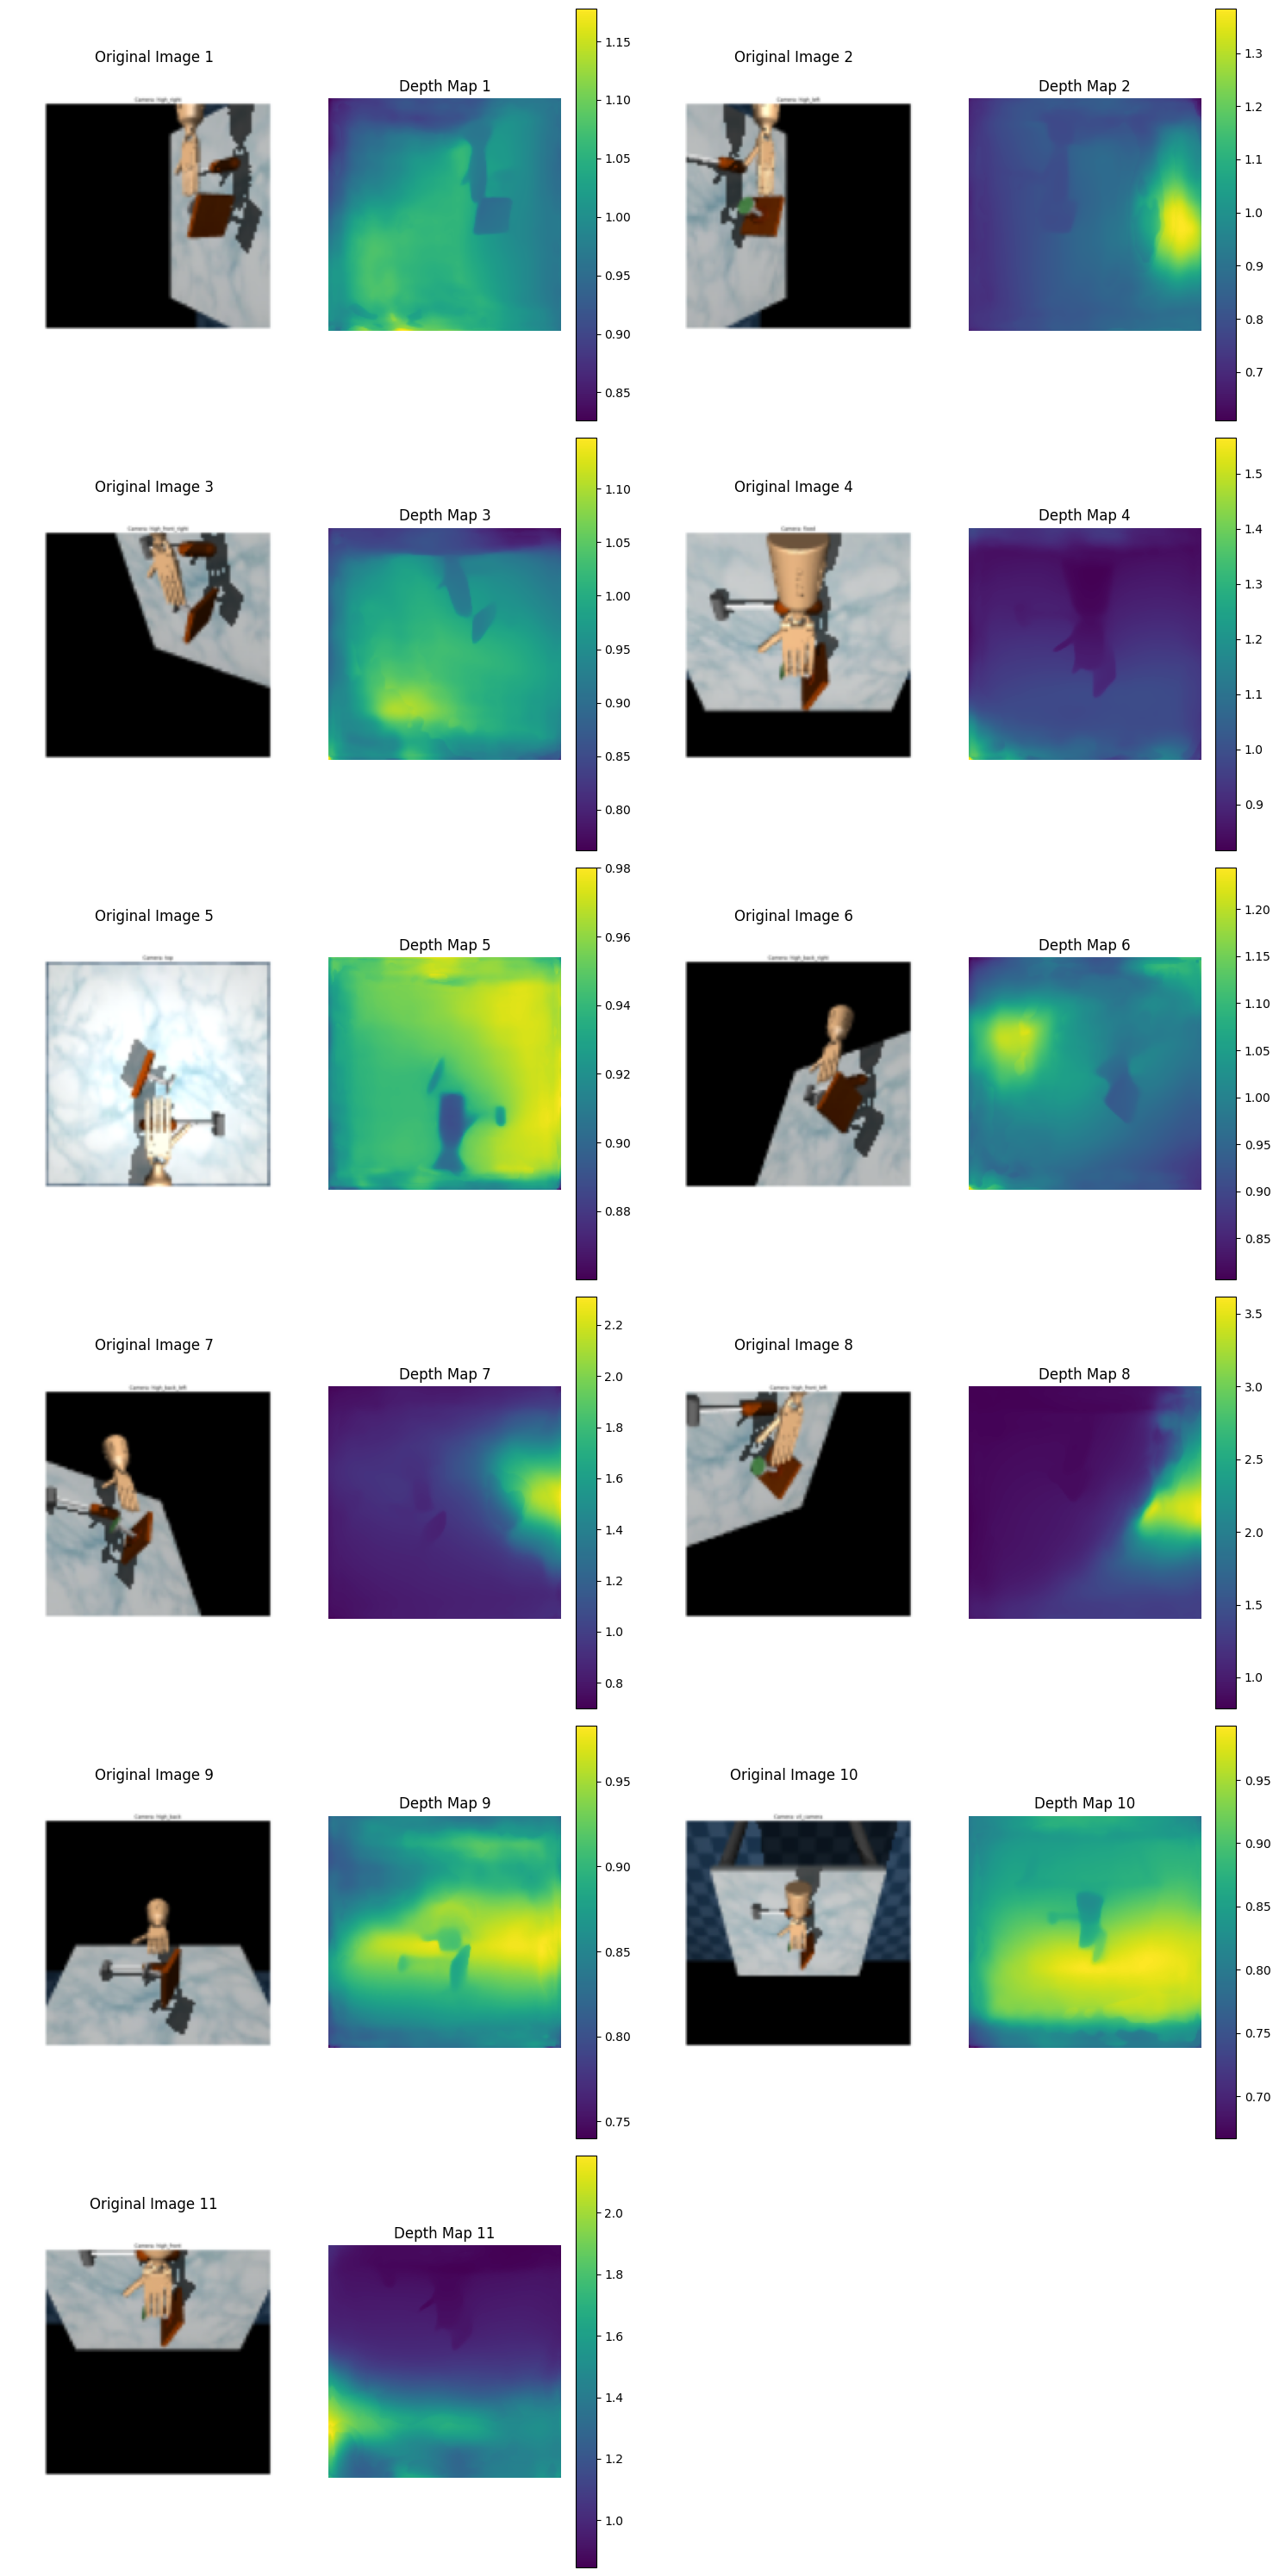

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_and_depth(predictions, num_cols=2):
    """Plot RGB images and their corresponding depth maps side by side
    
    Args:
        images: Tensor of shape (B, N, C, H, W) containing RGB images
        predictions: Dictionary containing depth predictions from VGGT model
        num_cols: Number of columns in the plot grid (default 2 for side-by-side)
    """
    # Move tensors to CPU and convert to numpy arrays
    images = predictions['images'].cpu().numpy()
    depth_maps = predictions['depth'].cpu().numpy()
    print(images.shape, depth_maps.shape)
    # Get batch size
    view_size = images.shape[1]
    
    # Calculate number of rows needed
    num_rows = (view_size + num_cols - 1) // num_cols
    
    # Create figure
    plt.figure(figsize=(15, 5*num_rows))
    
    # for i in range(batch_size):
    for i in range(view_size):
        # Plot original image
        plt.subplot(num_rows, num_cols*2, i*2 + 1)
        print(i, images[0, i].shape)
        plt.imshow(np.transpose(images[0, i ], (1,2,0)))  # Change from CxHxW to HxWxC
        plt.title(f'Original Image {i+1}')
        plt.axis('off')
        
        # Plot depth map
        plt.subplot(num_rows, num_cols*2, i*2 + 2)
        plt.imshow(depth_maps[0, i], cmap='viridis')  # Using viridis colormap for depth
        plt.title(f'Depth Map {i+1}')
        plt.colorbar()
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_images_and_depth(vggt_predictions)


In [15]:
import sys, os
sys.path.append('/home/san/dp3/vggt')
from vggt.models.vggt import VGGT

import torch 

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino.eval()
dino.to(device)

dino_image_batch = image_batch[0]
dino_predictions = dino(dino_image_batch)
dino_predictions.shape, dino_image_batch.shape

Using cache found in /home/san/.cache/torch/hub/facebookresearch_dinov2_main
/home/san/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/san/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/san/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


(torch.Size([11, 384]), torch.Size([11, 3, 168, 168]))

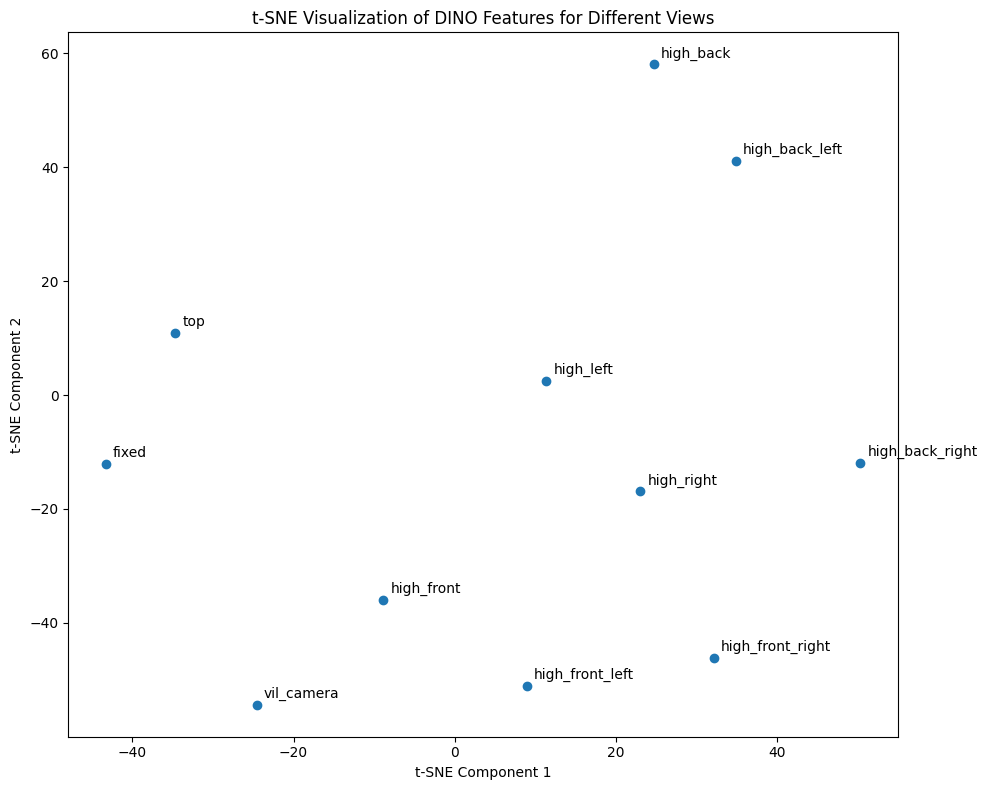

In [16]:
# Perform t-SNE on DINO features
from sklearn.manifold import TSNE
import numpy as np

# Convert DINO predictions to numpy for t-SNE
dino_features = dino_predictions.cpu().detach().numpy()

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Lower perplexity for small sample size
tsne_results = tsne.fit_transform(dino_features)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels for each point
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']
for i, txt in enumerate(view_names):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('t-SNE Visualization of DINO Features for Different Views')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()


In [9]:
vggt_features.shape, torch.mean(vggt_tokens, dim=-1).shape


((1, 11, 144, 2048), torch.Size([1, 11, 144]))

(11, 144)


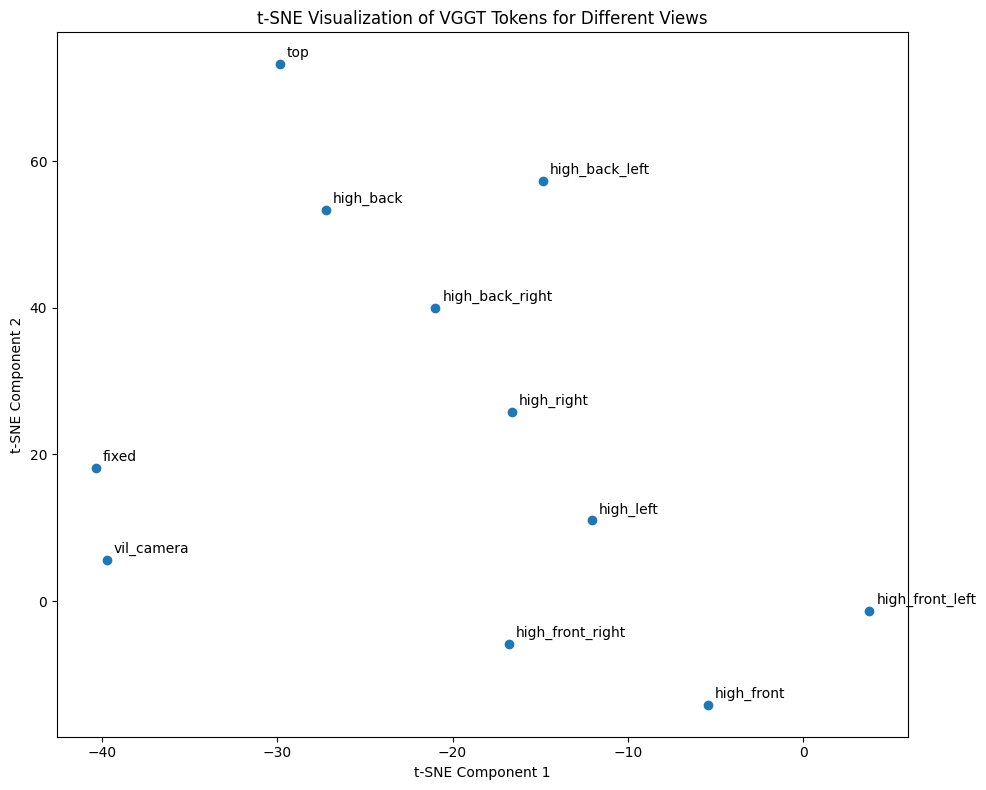

In [ ]:
# Perform t-SNE on VGGT tokens
from sklearn.manifold import TSNE
import numpy as np


# Convert VGGT tokens to numpy for t-SNE
vggt_features = torch.mean(vggt_tokens, dim=-1).cpu().detach().numpy()
vggt_features = vggt_features.reshape(vggt_features.shape[1], -1)
print(vggt_features.shape)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Lower perplexity for small sample size
tsne_results = tsne.fit_transform(vggt_features)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels for each point
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']
for i, txt in enumerate(view_names):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('t-SNE Visualization of VGGT Tokens for Different Views')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()


(11, 2048)


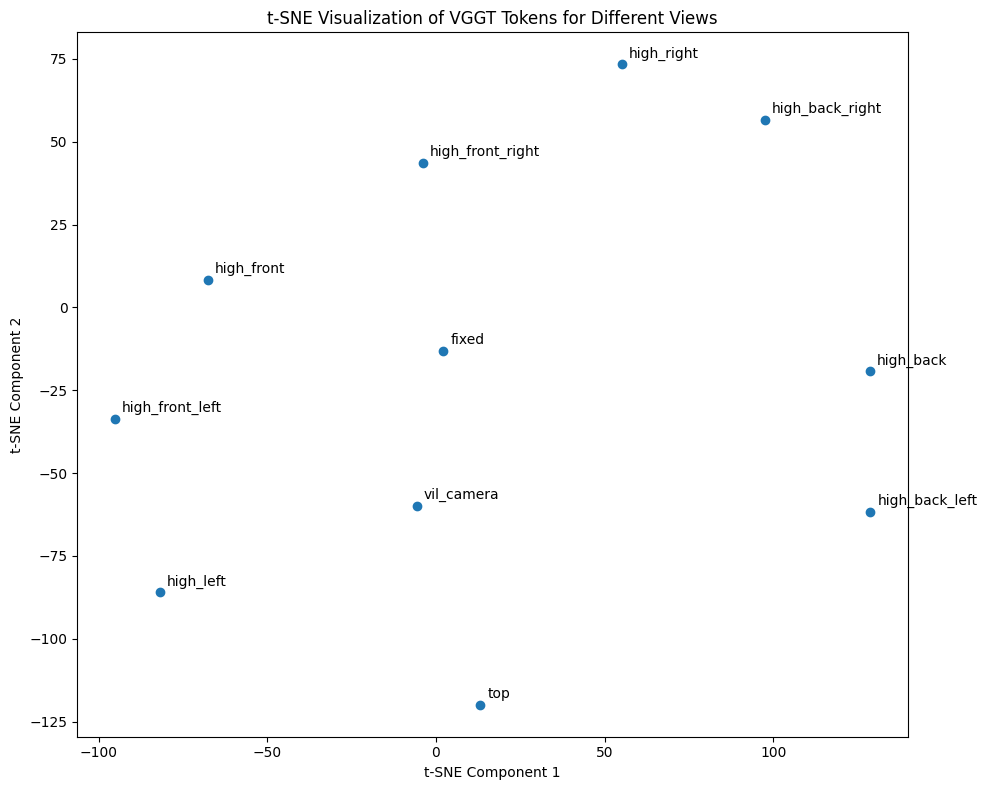

In [12]:
# Perform t-SNE on VGGT tokens
from sklearn.manifold import TSNE
import numpy as np


# Convert VGGT tokens to numpy for t-SNE : mean of patches 
vggt_features = torch.mean(vggt_tokens, dim=-2).cpu().detach().numpy()
vggt_features = vggt_features.reshape(vggt_features.shape[1], -1)
print(vggt_features.shape)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Lower perplexity for small sample size
tsne_results = tsne.fit_transform(vggt_features)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels for each point
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']
for i, txt in enumerate(view_names):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('t-SNE Visualization of VGGT Tokens for Different Views')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()


In [17]:
dino_features.shape, vggt_features.shape

((11, 384), (11, 2048))

In [24]:
import torch

# Function to compute the Gram matrix
def compute_gram(X):
    return X @ X.T

# Function to compute Linear CKA using the Gram matrices
def linear_cka_gram(X, Y):
    X = X - X.mean(0, keepdim=True)  # Center X
    Y = Y - Y.mean(0, keepdim=True)  # Center Y

    # Compute Gram matrices for both feature sets
    X_gram = compute_gram(X)
    Y_gram = compute_gram(Y)

    # Compute CKA
    dot_product_similarity = (X_gram * Y_gram).sum()
    normalization_x = (X_gram * X_gram).sum()
    normalization_y = (Y_gram * Y_gram).sum()

    return dot_product_similarity / (normalization_x.sqrt() * normalization_y.sqrt())

# Convert your numpy features to torch tensors
dino_tensor = torch.from_numpy(dino_features)
vggt_tensor = torch.from_numpy(vggt_features)

# Compute CKA
cka_value = linear_cka_gram(dino_tensor, vggt_tensor)
print(f"Linear CKA between DINO and VGGT: {cka_value.item():.4f}")

Linear CKA between DINO and VGGT: 0.7228


In [20]:
type(dino_features)

numpy.ndarray

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ======= Assume you have these already =======
# dino_embeds: (11, 384)
# vggt_embeds: (11, 2048)

# 1. Convert to numpy
dino_np = torch.from_numpy(dino_features).cpu().numpy()
vggt_np = torch.from_numpy(vggt_features).cpu().numpy()

print(dino_np.shape, vggt_np.shape)
# 2. First, reduce VGGT from 2048 -> 384 with PCA (optional)
pca_vggt = PCA(n_components=384)
vggt_pca = pca_vggt.fit_transform(vggt_np)

# 3. Stack DINO and VGGT features together (both 384d now)
features_combined = np.vstack([dino_np, vggt_pca])

# 4. t-SNE into 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init="pca", learning_rate='auto')
features_2d = tsne.fit_transform(features_combined)

# 5. Split back into DINO and VGGT
features_2d_dino = features_2d[:11]
features_2d_vggt = features_2d[11:]

# 6. Plot
plt.figure(figsize=(8, 6))
plt.scatter(features_2d_dino[:,0], features_2d_dino[:,1], c='blue', label='DINO', s=100, marker='o')
plt.scatter(features_2d_vggt[:,0], features_2d_vggt[:,1], c='red', label='VGGT', s=100, marker='^')

for i in range(11):
    plt.plot([features_2d_dino[i,0], features_2d_vggt[i,0]], 
             [features_2d_dino[i,1], features_2d_vggt[i,1]], 
             c='gray', linestyle='--', alpha=0.5)

plt.legend()
plt.title('t-SNE Comparison: DINO vs VGGT')
plt.grid(True)
plt.show()

(11, 384) (11, 2048)


ValueError: n_components=384 must be between 0 and min(n_samples, n_features)=11 with svd_solver='full'